# Polynomial Regression with SciKit-Learn

We saw how to create a very simple best fit line, but now let's greatly expand our toolkit to start thinking about the considerations of overfitting, underfitting, model evaluation, as well as multiple features!

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Sample Data

This sample data is from ISLR. It displays sales (in thousands of units) for a particular product as a function of advertising budgets (in thousands of dollars) for TV, radio, and newspaper media.

In [2]:
df = pd.read_csv("Advertising.csv")

In [3]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
# Everything BUT the sales column
X = df.drop('sales',axis=1)

In [5]:
X.head()

,TV,radio,newspaper
0,230.1,37.8,69.2
1,44.5,39.3,45.1
2,17.2,45.9,69.3
3,151.5,41.3,58.5
4,180.8,10.8,58.4


In [6]:
y = df['sales']

In [7]:
y.head()

0    22.1
1    10.4
2     9.3
3    18.5
4    12.9
Name: sales, dtype: float64

## SciKit Learn 

---

## Polynomial Regression

**From Preprocessing, import PolynomialFeatures, which will help us transform our original data set by adding polynomial features**

We will go from the equation in the form (shown here as if we only had one x feature):

$$\hat{y} = \beta_0 + \beta_1x_1 + \epsilon $$

and create more features from the original x feature for some *d* degree of polynomial.

$$\hat{y} = \beta_0 + \beta_1x_1 + \beta_1x^2_1 +  ... + \beta_dx^d_1 + \epsilon$$

Then we can call the linear regression model on it, since in reality, we're just treating these new polynomial features x^2, x^3, ... x^d as new features. Obviously we need to be careful about choosing the correct value of *d* , the degree of the model. Our metric results on the test set will help us with this!

**The other thing to note here is we have multiple X features, not just a single one as in the formula above, so in reality, the PolynomialFeatures will also take *interaction* terms into account for example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].**

In [8]:
from sklearn.preprocessing import PolynomialFeatures

In [9]:
polynomial_converter = PolynomialFeatures(degree=2,include_bias=False)

In [10]:
# Converter "fits" to data, in this case, reads in every X column
# Then it "transforms" and ouputs the new polynomial data
poly_features = polynomial_converter.fit_transform(X)

In [11]:
poly_features.shape

(200, 9)

In [12]:
X.shape

(200, 3)

In [13]:
X.iloc[0]

TV           230.1
radio         37.8
newspaper     69.2
Name: 0, dtype: float64

In [14]:
poly_features[0]
# wiskundige notatie!

array([2.301000e+02, 3.780000e+01, 6.920000e+01, 5.294601e+04,
       8.697780e+03, 1.592292e+04, 1.428840e+03, 2.615760e+03,
       4.788640e+03])

In [15]:
poly_features[0][:3]

array([230.1,  37.8,  69.2])

In [16]:
poly_features[0][:3]**2

array([52946.01,  1428.84,  4788.64])

The interaction terms $$x_1  \cdot x_2 \text{  and  } x_1  \cdot x_3 \text{  and  }   x_2  \cdot x_3 $$

In [17]:
230.1*37.8

8697.779999999999

In [18]:
230.1*69.2

15922.92

In [19]:
37.8*69.2

2615.7599999999998

## Train | Test Split

Make sure you have watched the Machine Learning Overview videos on Supervised Learning to understand why we do this step

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# random_state: 
# https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)

### Model for fitting on Polynomial Data

#### Create an instance of the model with parameters

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
model = LinearRegression(fit_intercept=True)

### Fit/Train the Model on the training data

**Make sure you only fit to the training data, in order to fairly evaluate your model's performance on future data**

In [24]:
model.fit(X_train,y_train)

LinearRegression()

In [25]:
model.coef_
#dit zijn de waardes van de ß0, ß1, ß2, ß3, ß4, ß5, ß6

array([ 5.17095811e-02,  1.30848864e-02,  1.20000085e-02, -1.10892474e-04,
        1.14212673e-03, -5.24100082e-05,  3.34919737e-05,  1.46380310e-04,
       -3.04715806e-05])


-----

## Evaluation on the Test Set

### Calculate Performance on Test Set

We want to fairly evaluate our model, so we get performance metrics on the test set (data the model has never seen before).

In [26]:
test_predictions = model.predict(X_test)

In [27]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [28]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [29]:
MAE

0.48967980448035886

In [30]:
MSE

0.44175055104033895

In [31]:
RMSE

0.6646431757269

In [32]:
df['sales'].mean()

14.0225

### Comparison with Simple Linear Regression

**Results on the Test Set (Note: Use the same Random Split to fairly compare!)**

* Simple Linear Regression:
    * MAE: 1.213
    * RMSE: 1.516

* Polynomial 2-degree:
    * MAE: 0.4896
    * RMSE: 0.664

---
---
## Choosing a Model

### Adjusting Parameters

Are we satisfied with this performance? Perhaps a higher order would improve performance even more! But how high is too high? It is now up to us to possibly go back and adjust our model and parameters, let's explore higher order Polynomials in a loop and plot out their error. This will nicely lead us into a discussion on Overfitting.

Let's use a for loop to do the following:

1. Create different order polynomial X data
2. Split that polynomial data for train/test
3. Fit on the training data
4. Report back the metrics on *both* the train and test results
5. Plot these results and explore overfitting

In [33]:
# TRAINING ERROR PER DEGREE
train_rmse_errors = []
# TEST ERROR PER DEGREE
test_rmse_errors = []

for d in range(1,10):
    
    # CREATE POLY DATA SET FOR DEGREE "d"
    polynomial_converter = PolynomialFeatures(degree=d,include_bias=False)
    poly_features = polynomial_converter.fit_transform(X)
    
    # SPLIT THIS NEW POLY DATA SET
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)
    
    # TRAIN ON THIS NEW POLY SET
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train,y_train)
    
    # PREDICT ON BOTH TRAIN AND TEST
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate Errors
    
    # Errors on Train Set
    train_RMSE = np.sqrt(mean_squared_error(y_train,train_pred))
    
    # Errors on Test Set
    test_RMSE = np.sqrt(mean_squared_error(y_test,test_pred))

    # Append errors to lists for plotting later
    
   
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)

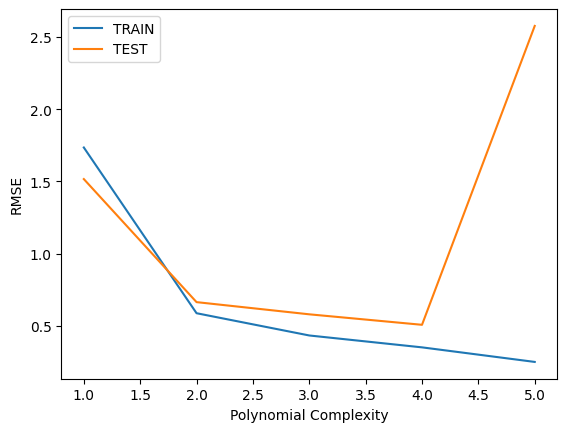

In [34]:
plt.plot(range(1,6),train_rmse_errors[:5],label='TRAIN')
plt.plot(range(1,6),test_rmse_errors[:5],label='TEST')
plt.xlabel("Polynomial Complexity")
plt.ylabel("RMSE")
plt.legend()

overfitting: te veel aanpassen waardoor verschil te groot wordt tussen train en test

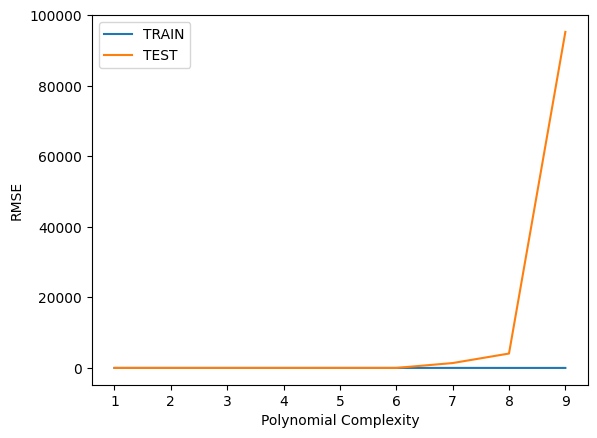

In [48]:
plt.plot(range(1,10),train_rmse_errors,label='TRAIN')
plt.plot(range(1,10),test_rmse_errors,label='TEST')
plt.xlabel("Polynomial Complexity")
plt.ylabel("RMSE")
plt.legend()

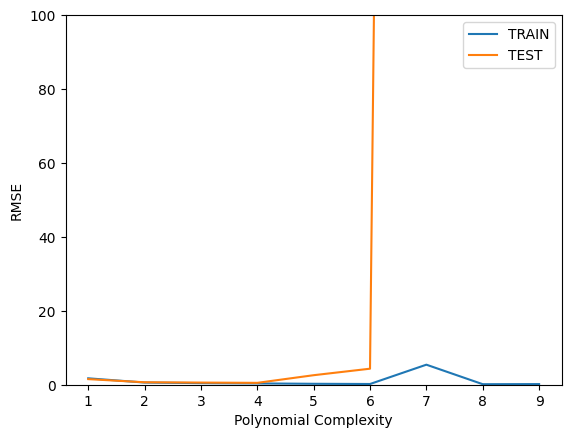

In [49]:
plt.plot(range(1,10),train_rmse_errors,label='TRAIN')
plt.plot(range(1,10),test_rmse_errors,label='TEST')
plt.xlabel("Polynomial Complexity")
plt.ylabel("RMSE")
plt.ylim(0,100)
plt.legend()

overfitting: model adapts to much to training data and can't generalize to test data

underfitting: model is too simple to capture the underlying structure of the data

High variance: model is too sensitive to small fluctuations in the training data

High bias: model is not sensitive enough to small fluctuations in the training data

## Finalizing Model Choice

There are now 2 things we need to save, the Polynomial Feature creator AND the model itself. Let's explore how we would proceed from here:

1. Choose final parameters based on test metrics
2. Retrain on all data
3. Save Polynomial Converter object
4. Save model

In [37]:
# Based on our chart, could have also been degree=4, but 
# it is better to be on the safe side of complexity
final_poly_converter = PolynomialFeatures(degree=3,include_bias=False)

In [38]:
final_model = LinearRegression()

In [39]:
final_model.fit(final_poly_converter.fit_transform(X),y)

LinearRegression()

### Saving Model and Converter

In [40]:
from joblib import dump, load

In [41]:
dump(final_model, 'sales_poly_model.joblib') 

['sales_poly_model.joblib']

In [42]:
dump(final_poly_converter,'poly_converter.joblib')

['poly_converter.joblib']

## Deployment and Predictions

### Prediction on New Data

Recall that we will need to **convert** any incoming data to polynomial data, since that is what our model is trained on. We simply load up our saved converter object and only call **.transform()** on the new data, since we're not refitting to a new data set.

**Our next ad campaign will have a total spend of 149k on TV, 22k on Radio, and 12k on Newspaper Ads, how many units could we expect to sell as a result of this?**

In [43]:
loaded_poly = load('poly_converter.joblib')
loaded_model = load('sales_poly_model.joblib')

In [44]:
campaign = [[149,22,12]]

In [45]:
campaign_poly = loaded_poly.transform(campaign)

c:\Users\miste\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [46]:
campaign_poly

array([[1.490000e+02, 2.200000e+01, 1.200000e+01, 2.220100e+04,
        3.278000e+03, 1.788000e+03, 4.840000e+02, 2.640000e+02,
        1.440000e+02, 3.307949e+06, 4.884220e+05, 2.664120e+05,
        7.211600e+04, 3.933600e+04, 2.145600e+04, 1.064800e+04,
        5.808000e+03, 3.168000e+03, 1.728000e+03]])

In [47]:
final_model.predict(campaign_poly)

array([14.64501014])

-----
---